## Voronoi Graphs

Voronoi diagrams can be tricky to construct. Luckilly Python's SciPy library already has an implementation of the [Voronoi method](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.spatial.Voronoi.html) built in!

The way this method works is that we need to feed in a set of points that, in our case, represent the obstacles, and create a **Voronoi()** object that contains a graph of the "ridges" that define the midline in free space between the obstacles.


The goal of this exercise is to read in the map of the world and generate a Voronoi graph for obstacles that are not simple points, but actual 2D polygons in the ground plane.

In [9]:
# Make the relevant imports including Voronoi methods
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import Voronoi, voronoi_plot_2d

# If you want to use the prebuilt bresenham method
# Import the Bresenham package
from bresenham import bresenham

%matplotlib inline 

plt.rcParams['figure.figsize'] = 13, 13

### Creating a Voronoi graph
Generate some random points and plot up the associated Voronoi graph

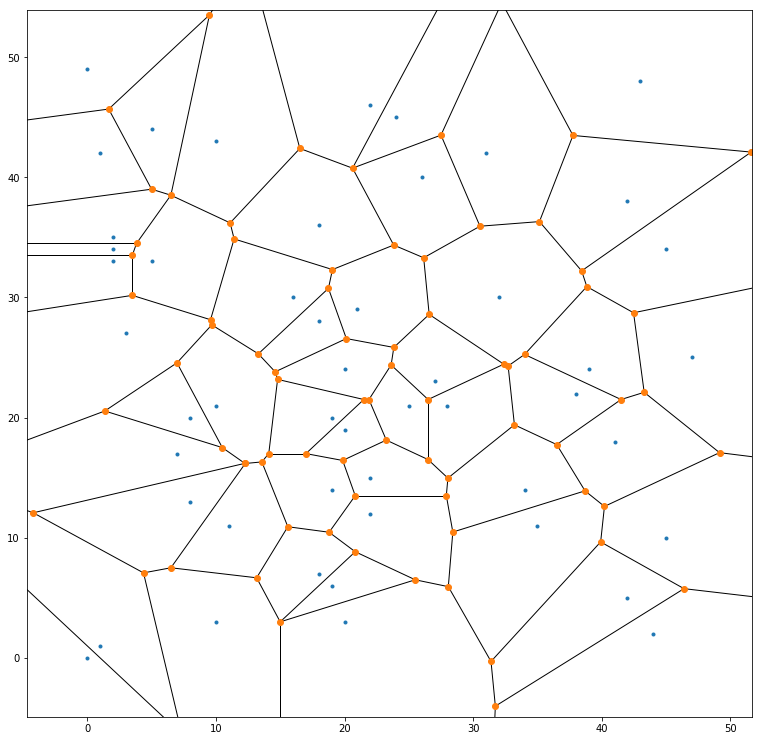

In [10]:
# Random points
points = np.random.randint(50, size=(50, 2))

# Graph
graph = Voronoi(points)
voronoi_plot_2d(graph)
plt.show()

### Read the obstacle map

The map is given in a `.csv` file, which contains obstacle data. The first line of the file gives the map center coordinates ([and this is here)](https://www.google.com/maps/place/37°47'32.9%22N+122°23'50.8%22W/@37.7924566,-122.4018247,16z/data=!4m5!3m4!1s0x0:0xc1332062f3ed759d!8m2!3d37.79248!4d-122.39745). The rest of the file is arranged in six columns $x$, $y$, $z$ and $\delta x$, $\delta y$, $\delta z$ such that:

* $x$ -> NORTH
* $y$ -> EAST
* $z$ -> ALTITUDE (positive up, note the difference with NED coords)

Each $(x, y, z)$ coordinate is the center of an obstacle. $\delta x$, $\delta y$, $\delta z$ are the half widths of the obstacles, meaning for example that an obstacle with $(x = 37, y = 12, z = 8)$ and $(\delta x = 5, \delta y = 5, \delta z = 8)$ is a 10 x 10 m obstacle that is 16 m high and is centered at the point $(x, y) = (37, 12)$ at a height of 8 m.

Given a map like this, the free space in the $(x, y)$ plane is a function of altitude, and we can plan a path around an obstacle, or simply fly over it!

We will extend each obstacle by a safety margin to create the equivalent of a 3 dimensional configuration space. 

The task is to extract a 2D grid map at 1 metre resolution of the configuration space for a particular altitude, where each value is assigned either a 0 or 1 representing feasible or infeasible (obstacle) spaces respectively.

In [11]:
# Read the obstacle data contained in the file: colliders.csv
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)

### Grid Creation with obstacle centres and Edges

Now modify the `create_grid()` method from previous exercises. In this new function we record obstacle centres and create a Voronoi graph around those points

In [12]:
def create_grid_and_edges(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    along with Voronoi graph edges given obstacle data and the
    drone's altitude.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min)))
    east_size = int(np.ceil((east_max - east_min)))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    
    # Define a list to hold Voronoi points
    points = []
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]

        if alt + d_alt + safety_distance > drone_altitude:
            #obstacle = [
            #    int(north - d_north - safety_distance - north_min_center),
            #    int(north + d_north + safety_distance - north_min_center),
            #    int(east - d_east - safety_distance - east_min_center),
            #    int(east + d_east + safety_distance - east_min_center),
            #]
            
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1
            
            # add center of obstacles to points list
            points.append([north - north_min, east - east_min])

    # Create a voronoi graph based on location of obstacle centres
    graph = Voronoi(points)

    # Check each edge from graph.ridge_vertices for collision
    edges = []
    
    for v in graph.ridge_vertices:       # each ridge v defined by two points
        p1 = graph.vertices[v[0]]        # coordinates (n,e) of point 1
        p2 = graph.vertices[v[1]]        # coordinates (n,e) of point 2
        
        # Bresenham line between p1 and p2
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        
        hit = False

        for c in cells:                  # for each point in the bresenham line
            # First check if it is off the map
            if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                hit = True
                break
            # Next check if it is in collision
            if grid[c[0], c[1]] == 1:
                hit = True
                break

        # If the edge does not hit on obstacle (no break), it is added to the list
        if not hit:
            # array to tuple for future graph creation step)
            p1 = (p1[0], p1[1])
            p2 = (p2[0], p2[1])
            edges.append((p1, p2))
    

    return grid, edges

In [13]:
# Define a flying altitude (feel free to change this)
drone_altitude = 5
safety_distance = 3
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print('Found %5d edges' % len(edges))

Found  1895 edges


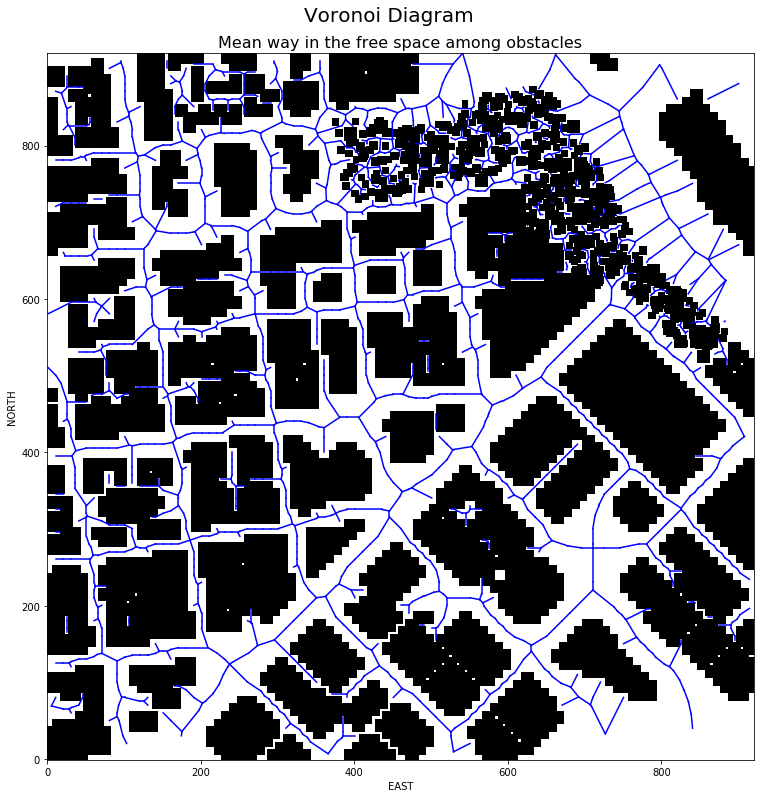

In [15]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
# Plot it up!
plt.imshow(grid, origin='lower', cmap='Greys') 

# Stepping through each edge
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.suptitle('Voronoi Diagram', fontsize=20, x=0.5, y=0.93)
plt.title('Mean way in the free space among obstacles', fontsize=16, x=0.5, y=1.0)

plt.show()